# Modelo de clasificación: crímenes CDMX

El presente script se realizó para estimar la clasificación de crímenes en la CDMX utilizando diferentes modelos de aprendizaje de máquina y comparándolos entre sí.


Junio 2020

In [76]:
## Importamos todas las paqueterías a utilizar
from tqdm import tqdm
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import shapefile as shp
import geoplot as gplt
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import  Point

# Importamos las paqueterías para correr nuestros modelos
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

In [77]:
# Cargamos la base de datos
crimes = pd.read_csv(r'carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico.csv', 
                     engine='python', encoding='utf_8', parse_dates =['fecha_hechos'])


## Índice

1. [Limpieza de base de datos](#1.-Limpieza-de-base-de-datos)<br>
2. [Análisis exploratorio](#2.-Análisis-exploratorio)<br>
3. [Modelos de Aprendizaje de Máquina](#3.-Modelos-de-Aprendizaje-de-Máquina)<br>
    3.1. [Preparación de los datos](#3.1-Preparación-de-los-datos)<br>
    3.2. [KNN](#3.2-KNN)<br>
    3.3. [Tree](#3.3-Tree)<br>
    3.4. [Random Forest](#3.4-Random-Forest)<br>
    3.5. [Gradient Boosting](#3.5-Gradient-Boosting)<br>
    3.6. [XGBoost](#3.6-XGBoost)<br>
4. [Resultados](#4.-Resultados)<br>

## 1. Limpieza de base de datos

In [78]:
# Exploramos la base de datos y vemos si hay valores nulos
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016445 entries, 0 to 1016444
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ao_hechos             1016046 non-null  float64
 1   mes_hechos            1016046 non-null  object 
 2   fecha_hechos          1016308 non-null  object 
 3   delito                1016445 non-null  object 
 4   categoria_delito      1016445 non-null  object 
 5   fiscalia              1016445 non-null  object 
 6   agencia               1016445 non-null  object 
 7   unidad_investigacion  1016219 non-null  object 
 8   alcaldia_hechos       1013346 non-null  object 
 9   colonia_hechos        975533 non-null   object 
 10  ao_inicio             1016444 non-null  float64
 11  mes_inicio            1016444 non-null  object 
 12  fecha_inicio          1016444 non-null  object 
 13  calle_hechos          1013723 non-null  object 
 14  calle_hechos2         404276 non-n

Por lo que vemos de la base de datos, hay algunas observaciones de la variable de fecha_inicio, latitud y longitud, las cuales son importantes para la creación de nuestro modelo.

Eliminarlas de la base de datos podría sesgar los resultados, por lo que primero haremos un análisis para ver la incidencia de crímenes a través del tiempo y luego las eliminaremos.

In [79]:
# Vemos los valores nulos de la base
crimes.isna().sum(axis=0)

ao_hechos                  399
mes_hechos                 399
fecha_hechos               137
delito                       0
categoria_delito             0
fiscalia                     0
agencia                      0
unidad_investigacion       226
alcaldia_hechos           3099
colonia_hechos           40912
ao_inicio                    1
mes_inicio                   1
fecha_inicio                 1
calle_hechos              2722
calle_hechos2           612169
longitud                 40021
latitud                  40021
geopoint                 40021
dtype: int64

In [80]:
# Vamos a filtrar los missing values de longitud y latitud y de fecha_hechos
crimes_filtrada = crimes[(~crimes['longitud'].isna()) &
                         (~crimes['fecha_hechos'].isna())].copy()

crimes_filtrada.isna().sum(axis=0)

ao_hechos                  204
mes_hechos                 204
fecha_hechos                 0
delito                       0
categoria_delito             0
fiscalia                     0
agencia                      0
unidad_investigacion       221
alcaldia_hechos              4
colonia_hechos             974
ao_inicio                    1
mes_inicio                   1
fecha_inicio                 1
calle_hechos              1586
calle_hechos2           588475
longitud                     0
latitud                      0
geopoint                     0
dtype: int64

In [81]:
# Convertimos a datetime la fecha de los hechos
crimes_filtrada["fecha_hechos"] = pd.to_datetime(crimes_filtrada["fecha_hechos"], yearfirst=True, errors='coerce').copy()

# Se filtran otros valores nulos que no se habían filtrado o no se detcatabne en el primer filtro
crimes_filtrada = crimes_filtrada[~crimes_filtrada["fecha_hechos"].isna()]


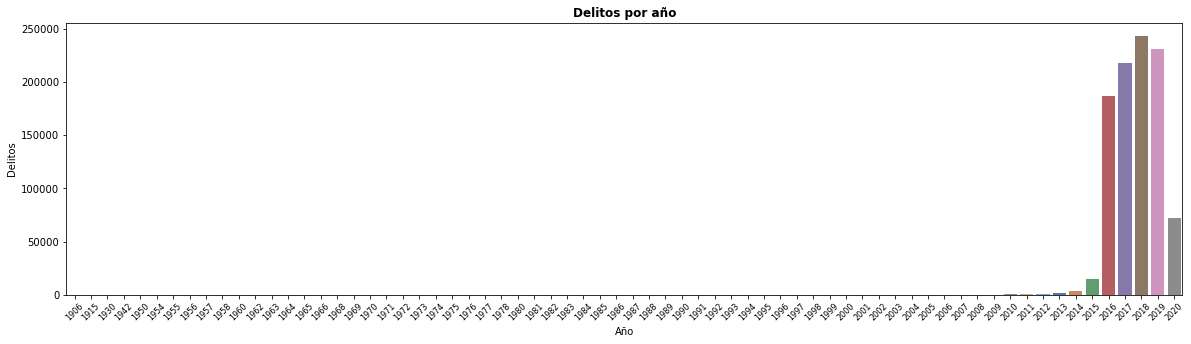

In [82]:
# Por último, sólo desde el año 2016 se cuenta con información que parece completa, como se observa en la siguiente gráfica

# Primero vemos los delitos por año
ao_crimenes = crimes_filtrada.groupby([crimes_filtrada['fecha_hechos'].dt.year])[['delito']].count()


# Graficamos
fig = plt.figure(figsize=(20, 5))

ax = fig.subplots(1, 1)

sns.barplot(x=ao_crimenes.index, y=ao_crimenes['delito'], palette="deep", ax=ax)

for tick in ax.get_xticklabels():
        tick.set_fontsize(8) 
        tick.set_rotation(45)

ax.set_title('Delitos por año', fontweight="bold")
ax.set_ylabel('Delitos')
ax.set_xlabel('Año')

plt.show()


In [83]:
# Por lo anterior, filtramos todos los valores de las fechas antes de 2016
print('Se filtraron {} observaciones que son antes del año 2016\n'.format(
    len(crimes_filtrada[crimes_filtrada['fecha_hechos'].dt.year < 2016])))


crimes_filtrada = crimes_filtrada[crimes_filtrada['fecha_hechos'].dt.year >= 2016]

crimes_filtrada.info()

Se filtraron 25375 observaciones que son antes del año 2016

<class 'pandas.core.frame.DataFrame'>
Int64Index: 950725 entries, 0 to 1016444
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ao_hechos             950725 non-null  float64       
 1   mes_hechos            950725 non-null  object        
 2   fecha_hechos          950725 non-null  datetime64[ns]
 3   delito                950725 non-null  object        
 4   categoria_delito      950725 non-null  object        
 5   fiscalia              950725 non-null  object        
 6   agencia               950725 non-null  object        
 7   unidad_investigacion  950537 non-null  object        
 8   alcaldia_hechos       950721 non-null  object        
 9   colonia_hechos        949769 non-null  object        
 10  ao_inicio             950724 non-null  float64       
 11  mes_inicio            950724 non-null  object        
 

De la base podemos ver dos clasificaciones de robo, la de "delito" y la de "categoria_delito". Estas dos no parecen tener homologado un criterio y por lo mismo se vamos a tener que crear un criterio, homologar y descartar algunos delitos, con el fin de priorizar nuestro análisis de delitos de impacto como robo, asesinato, secuestro y descartar aquellos que son menos directos como amenazas, fraude y robo sin violencia o hechos no delictivos.

In [84]:
print('La base tiene {} categorías diferentes para la columna de delito y {} para la columna de categoria_delito'.format(
len(crimes_filtrada['delito'].unique()), len(crimes_filtrada['categoria_delito'].unique())
)
     )

La base tiene 335 categorías diferentes para la columna de delito y 18 para la columna de categoria_delito


In [85]:
# Vemos el conteo de la clasificación de cartegoría delito
crimes_filtrada.groupby(['categoria_delito']).size()

categoria_delito
DELITO DE BAJO IMPACTO                                     735610
FEMINICIDIO                                                     1
HECHO NO DELICTIVO                                          43241
HOMICIDIO DOLOSO                                             5021
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO                3709
PLAGIO O SECUESTRO                                              1
ROBO A CASA HABITACIÓN CON VIOLENCIA                         2466
ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA      1914
ROBO A NEGOCIO CON VIOLENCIA                                16988
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA      3644
ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA                 983
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA       10295
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                       10112
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA        58718
ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA                   

Como se puede observar, hay algunas categorías que tienen muy pocas ocurrencias y esto se puede deber a que son categorías nuevas. 

Por lo anterior, la categoría de __FEMINICIDIO__ se recategorizará a __HOMICIDIO DOLOSO__ y la categoría de __PLAGIO O SECUESTRO__ a __SECUESTRO__

In [86]:
# Recategorizamos
crimes_filtrada.replace({'categoria_delito': 'FEMINICIDIO'}, 'HOMICIDIO DOLOSO', inplace=True)
crimes_filtrada.replace({'categoria_delito': 'PLAGIO O SECUESTRO'}, 'SECUESTRO', inplace=True)


In [87]:
# Volvemos a imprimier el conteo de la categoría de delitos
crimes_filtrada.groupby(['categoria_delito']).size()

categoria_delito
DELITO DE BAJO IMPACTO                                     735610
HECHO NO DELICTIVO                                          43241
HOMICIDIO DOLOSO                                             5022
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO                3709
ROBO A CASA HABITACIÓN CON VIOLENCIA                         2466
ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA      1914
ROBO A NEGOCIO CON VIOLENCIA                                16988
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA      3644
ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA                 983
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA       10295
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                       10112
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA        58718
ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA                      513
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                        53917
SECUESTRO                                                  

Por otro lado, como se observa en el conteo de las categorías de delitos, la categoría de __DELITO DE BAJO IMPACTO__ es la que contiene la mayoría de las observaciones. Al respecto, se realizó un análisis de cada uno de los delitos dentro de esta categoría y se encontró que algunos podrían tener su propia categoría y otros podrían reclasificarse.

Por un lado, se crea la categoría de __EXTORSION Y TENTATIVA DE EXTORSION__ y se categorizan 28 tipos de delitos.

In [88]:
#  Primero creamos una función para reemplazar categorías sin son de cierto delito
def remplaza_delito(lista_delito, categoria):
    
    for delito in lista_delito:

        crimes_filtrada.loc[crimes_filtrada['delito'] == delito, 'categoria_delito'] = categoria
        

# Creamos primero la lista de delitos que los vamos a reclasificar como ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA
# Así como vamos a renombrar esta categoría para que incluya al transporte público en general, menos el metro y el taxi que son otra categoría
trans_pub = ['ROBO A PASAJERO A BORDO DE TRANSPORTE PÚBLICO CON VIOLENCIA',
            'ROBO A PASAJERO A BORDO DE METROBUS CON VIOLENCIA',
            'ROBO A PASAJERO A BORDO DE PESERO Y VEHICULO CON VIOLENCIA',
            'ROBO A PASAJERO EN AUTOBÚS FORÁNEO CON VIOLENCIA',
            'ROBO A PASAJERO EN TROLEBUS CON VIOLENCIA',
            'ROBO A PASAJERO EN RTP CON VIOLENCIA',
            'ROBO A PASAJERO EN ECOBUS CON VIOLENCIA',
            'ROBO A TRANSEUNTE EN TERMINAL DE PASAJEROS CON VIOLENCIA',
            'ROBO A PASAJERO EN TREN LIGERO CON VIOLENCIA',
            'ROBO A PASAJERO EN TREN SUBURBANO CON VIOLENCIA']


# La lista de clasifciación de ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA
taxi = ['ROBO A PASAJERO / CONDUCTOR DE TAXI CON VIOLENCIA',
        'ROBO A TRANSEUNTE CONDUCTOR DE TAXI PUBLICO Y PRIVADO CON VIOLENCIA']

# Lista para renombrar los delitos de ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA
trans = ['ROBO A TRANSEUNTE EN NEGOCIO CON VIOLENCIA',
        'ROBO A TRANSEUNTE DE CELULAR CON VIOLENCIA',
        'ROBO A TRANSEUNTE EN RESTAURANT CON VIOLENCIA',
        'ROBO A TRANSEUNTE EN PARQUES Y MERCADOS CON VIOLENCIA',
        'ROBO A TRANSEUNTE EN CINE CON VIOLENCIA',
        'ROBO A TRANSEUNTE Y VEHICULO CON VIOLENCIA',
        'ROBO A TRANSEUNTE EN HOTEL CON VIOLENCIA']

# Lista para renombrar a delitos de ROBO DE VEHÍCULO CON Y SIN VIOLENCIA
robo_auto = ['ROBO A PASAJERO / CONDUCTOR DE VEHICULO CON VIOLENCIA']

# Lista para renombrar el delito de SECUESTRO
secuestro = ['SECUESTRO EXPRESS (PARA COMETER ROBO O EXTORSIÓN)',
            'PRIVACION DE LA LIBERTAD PERSONAL (REALIZAR ACTO SEXUAL)',
            'DESAPARICION FORZADA DE PERSONAS',
            'PRIVACION DE LA LIBERTAD PERSONAL',
            'PRIV. ILEGAL DE LA LIB. Y ROBO DE VEHICULO']

# Para crear la categoría de EXTORSION Y TENTATIVA DE EXTORSION

extorsion = ['TENTATIVA DE EXTORSION',
             'EXTORSION',
             'COBRANZA ILEGITIMA']


# Corremos las funciones
remplaza_delito(trans_pub, 'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA')
remplaza_delito(taxi, 'ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA')
remplaza_delito(trans, 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA')
remplaza_delito(robo_auto, 'ASALTO A AUTOTRANSPORTE')
remplaza_delito(secuestro, 'SECUESTRO')
remplaza_delito(extorsion, 'EXTORSION Y TENTATIVA DE EXTORSION')


# Reemplazamos el nombre de la categoria de ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA por 
# ROBO A PASAJERO A BORDO DE TRANS. PUB. CON Y SIN VIOLENCIA
crimes_filtrada.replace({'categoria_delito': 'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA'}, 
                        'ROBO A PASAJERO A BORDO DE TRANS. PUB. CON Y SIN VIOLENCIA', inplace=True)


In [89]:
# Por último, con tal de dimsinuir las clasifciaciones, haremos una fusión de varias de estas que son parecidas

# Primero juntemos las categorías para asaltos a transeuntes
replace_1 = ['ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA', 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA']
crimes_filtrada['categoria_delito'] = crimes_filtrada['categoria_delito'].replace(replace_1, 'ROBO A TRANSEUNTE')

# Luego a asaltos a transporte público
replace_2 = ['ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA', 'ROBO A PASAJERO A BORDO DE TRANS. PUB. CON Y SIN VIOLENCIA', 
            'ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA']
crimes_filtrada['categoria_delito'] = crimes_filtrada['categoria_delito'].replace(replace_2, 'ASALTO EN TRANSPORTE PUBLICO')

# Luego a asaltos a autotranporte
replace_3 = ['ROBO A REPARTIDOR CON Y SIN VIOLENCIA', 'ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA']
crimes_filtrada['categoria_delito'] = crimes_filtrada['categoria_delito'].replace(replace_3, 'ASALTO A AUTOTRANSPORTE')

In [90]:
# Volvemos a imprimier el conteo de la categoría de delitos
crimes_filtrada.groupby(['categoria_delito']).size()

categoria_delito
ASALTO A AUTOTRANSPORTE                           22031
ASALTO EN TRANSPORTE PUBLICO                      22125
DELITO DE BAJO IMPACTO                           687000
EXTORSION Y TENTATIVA DE EXTORSION                 9538
HECHO NO DELICTIVO                                43241
HOMICIDIO DOLOSO                                   5022
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO      3709
ROBO A CASA HABITACIÓN CON VIOLENCIA               2466
ROBO A NEGOCIO CON VIOLENCIA                      16988
ROBO A TRANSEUNTE                                 77254
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA              53917
SECUESTRO                                          4001
VIOLACIÓN                                          3433
dtype: int64

Por otro lado, debemos ver si no hay inconsistencias en la información de la latitud y longitudes de los crímines.

Por lo anterior, debemos de dibujar un mapa y poner el puntos en donde se registraron los crímines para ver si no hay ourliers.

Para estos vamos a usar un archivo shapefile que dibuja los límites de las acladías de la Ciudad de México, y el cual se puede encontrar en la siguiente liga: https://datos.cdmx.gob.mx/dataset/limite-de-las-alcaldias

El código para mapear tiene su base en el siguiente artículo: https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

In [91]:

shp_path = r'mapa2\limite-de-las-alcaldias.shp'
cdmx = shp.Reader(shp_path)

def read_shapefile(cdmx):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in cdmx.fields][1:]
    records = cdmx.records()
    shps = [s.points for s in cdmx.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

mapa = read_shapefile(cdmx)

def plot_map(cdmx, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in cdmx.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            #plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)


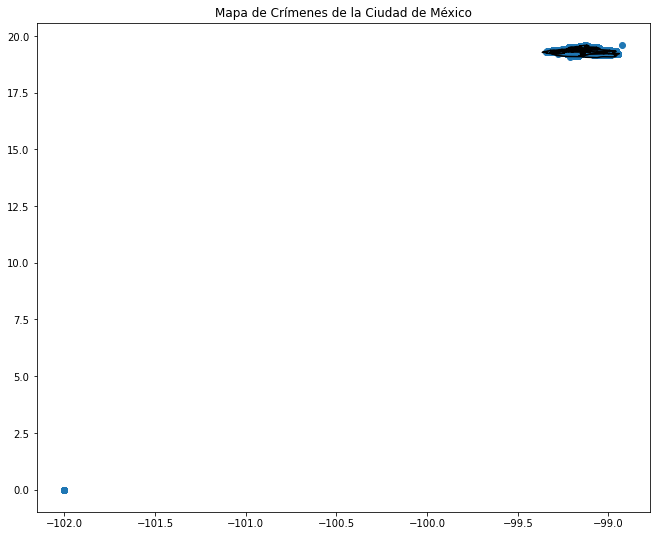

In [92]:
# Se grafica el mapa de crímines para ver si hay algunos outliers
plot_map(cdmx)
plt.scatter(x=crimes_filtrada['longitud'], y=crimes_filtrada['latitud'])
plt.title('Mapa de Crímenes de la Ciudad de México')

plt.show()

Como se puede ver en la gráfica, hay algunas observaciones no se encuentre bien llenada, ya que la latitud es igual a cero. 

Por lo que se procede a filtrarla.


In [93]:
print('Hay {} observaciones con latitud igual a cero'.format(len(crimes_filtrada[crimes_filtrada['latitud'] == 0])))

Hay 9 observaciones con latitud igual a cero


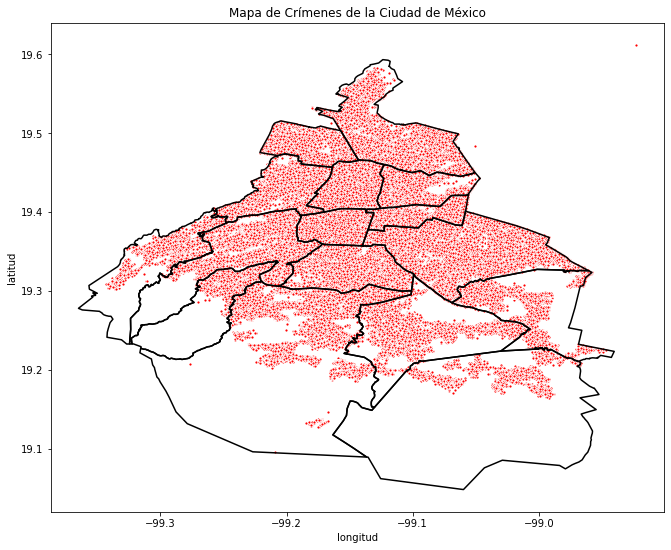

In [94]:
# Se quita de la base los crímenes con el dato de latitud igual a cero y se grafica
crimes_filtrada = crimes_filtrada[crimes_filtrada['latitud'] != 0]

plot_map(cdmx)
sns.scatterplot(x=crimes_filtrada['longitud'], y=crimes_filtrada['latitud'], marker = '.', alpha=1, color='red')
plt.title('Mapa de Crímenes de la Ciudad de México')

plt.show()

In [95]:
# Ahora vemos si hay avlores atípicos en las alcadías, por lo que realizamos un conteo
crimes_filtrada['alcaldia_hechos'].value_counts(dropna=False)

CUAUHTEMOC                148271
IZTAPALAPA                143356
GUSTAVO A MADERO           95574
BENITO JUAREZ              82653
COYOACAN                   64760
ALVARO OBREGON             64628
MIGUEL HIDALGO             63823
TLALPAN                    56269
VENUSTIANO CARRANZA        55606
AZCAPOTZALCO               47323
IZTACALCO                  41516
XOCHIMILCO                 29723
TLAHUAC                    22059
LA MAGDALENA CONTRERAS     15078
CUAJIMALPA DE MORELOS      13808
MILPA ALTA                  6263
NaN                            4
NAUCALPAN DE JUAREZ            1
CHALCO                         1
Name: alcaldia_hechos, dtype: int64

De la lista anterior, podemos ver que hay municipios que pertenecen al EDOMEX (CHALCO y NAUCALPAN DE JUAREZ) y algunos valores nulos, por lo que los sacaremos de la muestra.

In [96]:
# Primero quitamos los valores nulos
crimes_filtrada = crimes_filtrada[~crimes_filtrada["alcaldia_hechos"].isna()]

# Quitamos los municipios del EDOMEX
crimes_filtrada = crimes_filtrada[(crimes_filtrada['alcaldia_hechos'] != 'CHALCO') & 
                                  (crimes_filtrada['alcaldia_hechos'] != 'NAUCALPAN DE JUAREZ')]

In [97]:
# Volvemos a imprimir
crimes_filtrada['alcaldia_hechos'].value_counts(dropna=False)

CUAUHTEMOC                148271
IZTAPALAPA                143356
GUSTAVO A MADERO           95574
BENITO JUAREZ              82653
COYOACAN                   64760
ALVARO OBREGON             64628
MIGUEL HIDALGO             63823
TLALPAN                    56269
VENUSTIANO CARRANZA        55606
AZCAPOTZALCO               47323
IZTACALCO                  41516
XOCHIMILCO                 29723
TLAHUAC                    22059
LA MAGDALENA CONTRERAS     15078
CUAJIMALPA DE MORELOS      13808
MILPA ALTA                  6263
Name: alcaldia_hechos, dtype: int64

In [98]:
lista_categoria_bajo_impacto = ['DELITO DE BAJO IMPACTO',
                               'HECHO NO DELICTIVO']

# Se crea una columna con 1 si el delito es parte de la lista de delitos de impacto y cero lo contrario
crimes_filtrada['delitos_impacto'] = [1 if delito not in lista_categoria_bajo_impacto else 0 for delito in crimes_filtrada['categoria_delito']]

# Se crea una base con sólo los crímenes de impacto
crimes_impacto = crimes_filtrada[crimes_filtrada['delitos_impacto'] == 1].copy()

In [99]:
print('De la lista de delitos de impacto nos quedamos con {} observaciones'.format(len(crimes_impacto)))

De la lista de delitos de impacto nos quedamos con 220476 observaciones


## 2. Análisis exploratorio

In [100]:
# Filtramos los la base para solo tener los valores de los delitos de impacto
delitos_ao = crimes_filtrada[crimes_filtrada['delitos_impacto'] == 1]

# Lo primero que queremos ver cuáles son las categorías de crímines más comúnes
delitos_ao = delitos_ao.groupby([delitos_ao['fecha_hechos'].dt.year, 'categoria_delito']).size()

# Lo convertimos a Dataframe
delitos_ao = pd.DataFrame(delitos_ao).reset_index()

# Renombramos columnas
delitos_ao.columns = ['fecha_hechos', 'categoria_delito', 'conteo']

# Ordenamos
delitos_ao = delitos_ao.sort_values(by=['fecha_hechos', 'conteo'], ascending=False)

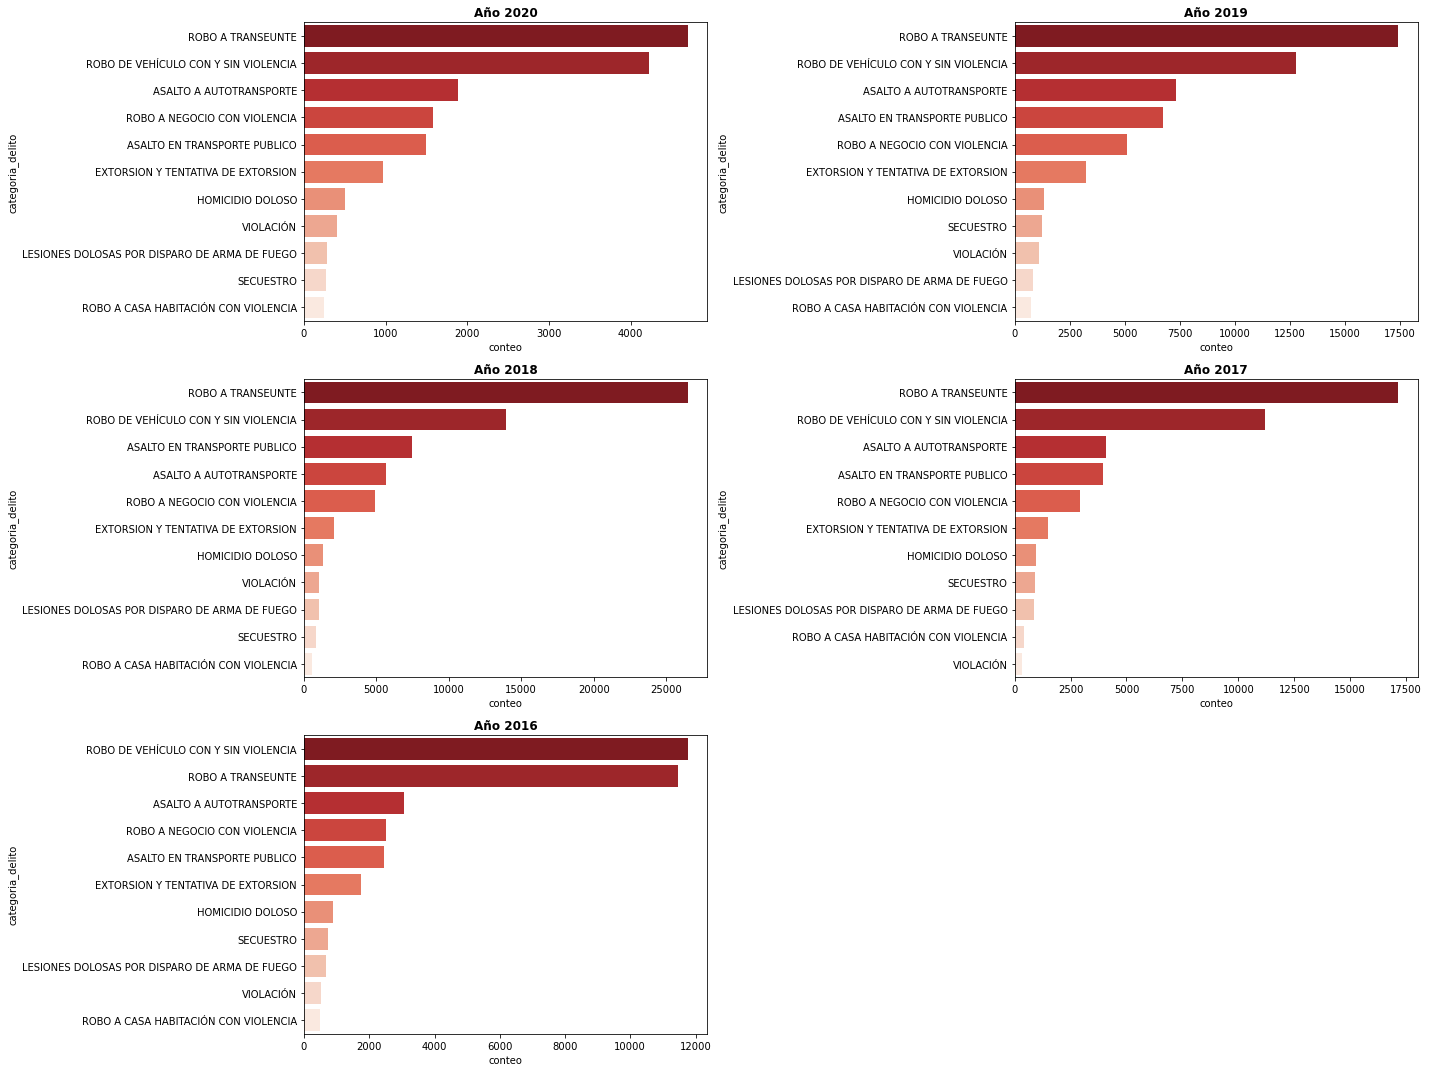

In [101]:
fig = plt.figure(figsize=(20, 15))

(ax1, ax2), (ax3, ax4), (ax5, ax6) = fig.subplots(3, 2)

for anio, ax in zip(delitos_ao['fecha_hechos'].unique(), [ax1, ax2, ax3, ax4, ax5, ax6]):

    delitos_ao_ = delitos_ao[delitos_ao['fecha_hechos'] == anio]                
                    
    sns.barplot(x="conteo", y="categoria_delito", data=delitos_ao_,
                label="Total", ax=ax, palette="Reds_r")
    
    ax.set_title('Año {}'.format(anio), fontweight="bold")

plt.tight_layout()
fig.delaxes(ax6) 
plt.show()

Podemos ver que de un año para otro no cambia mucho los tipos de crímenes, la mayoría son robos.

In [102]:
# Ahora vemos la información por hora
# Filtramos los la base para solo tener los valores de los delitos de impacto
delitos_hora = crimes_filtrada[crimes_filtrada['delitos_impacto'] == 1]

# Lo primero que queremos ver cuáles son las categorías de crímines más comúnes
delitos_hora = delitos_hora.groupby([delitos_hora['fecha_hechos'].dt.hour]).size()

# Lo convertimos a Dataframe
delitos_hora = pd.DataFrame(delitos_hora).reset_index()

# Renombramos columnas
delitos_hora.columns = ['hora_hechos', 'conteo']

# Ordenamos
delitos_hora = delitos_hora.sort_values(by=['hora_hechos', 'conteo'], ascending=False)


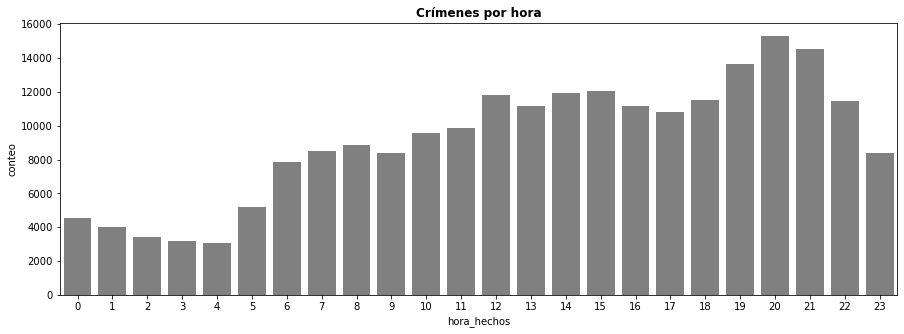

In [103]:
fig = plt.figure(figsize=(15, 5))

ax = fig.subplots(1, 1)

sns.barplot(x="hora_hechos", y="conteo", data=delitos_hora,
            label="Total", color="grey", ax=ax)

ax.set_title('Crímenes por hora', fontweight="bold")

plt.show()

In [104]:
# Agrupamos los delitos por hora y contamos su frecuencia
delitos_hora_2 = crimes_impacto.groupby([crimes_impacto['fecha_hechos'].dt.hour, 'categoria_delito']).size()

# Lo convertimos a Dataframe
delitos_hora_2 = pd.DataFrame(delitos_hora_2).reset_index()

# Renombramos columnas
delitos_hora_2.columns = ['hora_hechos', 'categoria_delito', 'conteo']

In [105]:
# Normalizamos
for crimen in delitos_hora_2['categoria_delito'].unique():
    
    minimo = min(delitos_hora_2[delitos_hora_2['categoria_delito'] == crimen]['conteo'])
    
    delitos_hora_2.loc[delitos_hora_2['categoria_delito'] == crimen, 'conteo'] = delitos_hora_2.loc[delitos_hora_2['categoria_delito'] == crimen, 'conteo'] / minimo

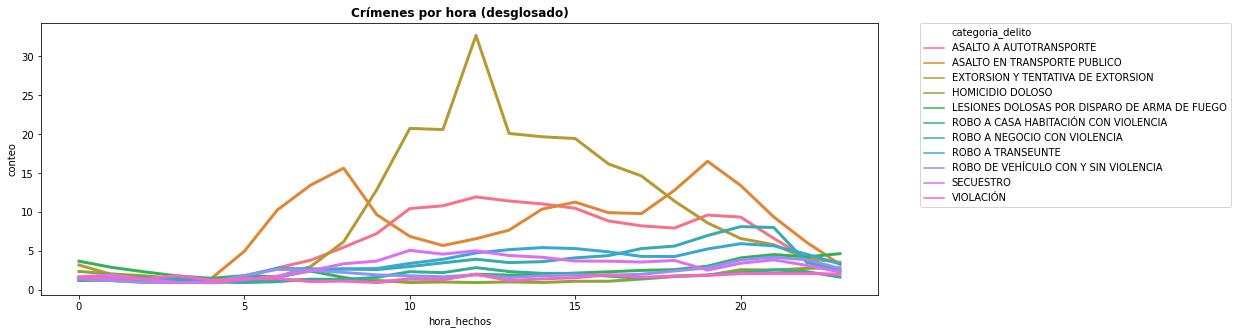

In [106]:
# Ahora graficamos los crímenes por hora pero de cada categoría de delito
fig = plt.figure(figsize=(15, 5))

ax = fig.subplots(1, 1)

sns.lineplot(x="hora_hechos", y="conteo",
             hue="categoria_delito", lw=3,
             data=delitos_hora_2, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Crímenes por hora (desglosado)', fontweight="bold")
plt.show()

In [107]:
# Filtramos los la base para solo tener los valores de los delitos de impacto
delitos_dia = crimes_filtrada[crimes_filtrada['delitos_impacto'] == 1]

# Lo primero que queremos ver cuáles son las categorías de crímines más comúnes
delitos_dia = delitos_dia.groupby([delitos_dia['fecha_hechos'].dt.day_name()]).size()

# Lo convertimos a Dataframe
delitos_dia = pd.DataFrame(delitos_dia).reset_index()

# Renombramos columnas
delitos_dia.columns = ['día_hechos', 'conteo']

# Ordenamos
delitos_dia = delitos_dia.sort_values(by=['conteo'], ascending=False)


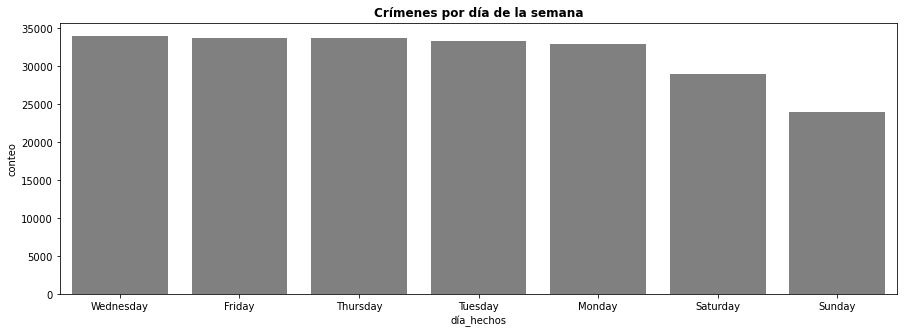

In [108]:
fig = plt.figure(figsize=(15, 5))

ax = fig.subplots(1, 1)

sns.barplot(x="día_hechos", y="conteo", data=delitos_dia,
            label="Total", color="grey", ax=ax)

ax.set_title('Crímenes por día de la semana', fontweight="bold")

plt.show()

In [109]:
# Agrupamos los delitos por día de la semana y contamos su frecuencia
delitos_dia_2 = crimes_impacto.groupby([crimes_impacto['fecha_hechos'].dt.day_name(), 'categoria_delito']).size()

# Lo convertimos a Dataframe
delitos_dia_2 = pd.DataFrame(delitos_dia_2).reset_index()

# Renombramos columnas
delitos_dia_2.columns = ['dia_hechos', 'categoria_delito', 'conteo']

In [110]:
# Normalizamos
for crimen in delitos_dia_2['categoria_delito'].unique():
    
    minimo = min(delitos_dia_2[delitos_dia_2['categoria_delito'] == crimen]['conteo'])
    
    delitos_dia_2.loc[delitos_dia_2['categoria_delito'] == crimen, 'conteo'] = delitos_dia_2.loc[delitos_dia_2['categoria_delito'] == crimen, 'conteo'] / minimo

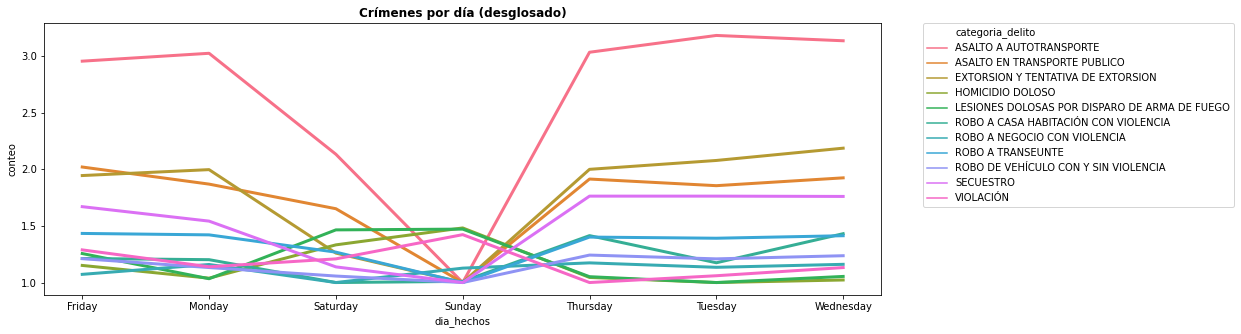

In [111]:
# Ahora graficamos los crímenes por día pero de cada categoría de delito
fig = plt.figure(figsize=(15, 5))

ax = fig.subplots(1, 1)

sns.lineplot(x="dia_hechos", y="conteo",
             hue="categoria_delito", lw=3,
             data=delitos_dia_2, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Crímenes por día (desglosado)', fontweight="bold")
plt.show()

In [112]:
# Ahora exploramos por alcaldía
# Filtramos los la base para solo tener los valores de los delitos de impacto
delitos_alcaldia = crimes_filtrada[crimes_filtrada['delitos_impacto'] == 1]

# Lo primero que queremos ver cuáles son las categorías de crímines más comúnes
delitos_alcaldia = delitos_alcaldia.groupby(['alcaldia_hechos']).size()

# Lo convertimos a Dataframe
delitos_alcaldia = pd.DataFrame(delitos_alcaldia).reset_index()

# Renombramos columnas
delitos_alcaldia.columns = ['alcaldia_hechos', 'conteo']

# Ordenamos
delitos_alcaldia = delitos_alcaldia.sort_values(by=['conteo'], ascending=False)

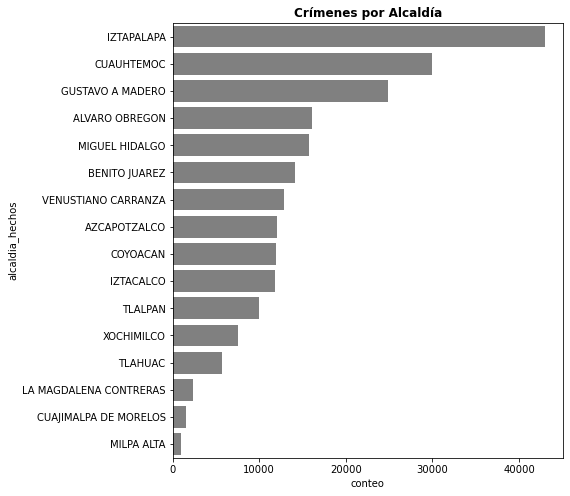

In [113]:
fig = plt.figure(figsize=(7, 8))

ax = fig.subplots(1, 1)

sns.barplot(x="conteo", y="alcaldia_hechos", data=delitos_alcaldia,
            label="Total", color="grey", ax=ax)

ax.set_title('Crímenes por Alcaldía', fontweight="bold")

plt.show()

In [114]:
# Ahora exploramos por alcaldía
# Filtramos los la base para solo tener los valores de los delitos de impacto
delitos_diarios = crimes_filtrada[crimes_filtrada['delitos_impacto'] == 1]

# Lo primero que queremos contar los delitos diarios
delitos_diarios = delitos_diarios.groupby([crimes_filtrada['fecha_hechos'].dt.date]).size()

# Lo convertimos a Dataframe
delitos_diarios = pd.DataFrame(delitos_diarios).reset_index()

# Renombramos columnas
delitos_diarios.columns = ['dia', 'conteo']

# Ordenamos
delitos_diarios = delitos_diarios.sort_values(by=['conteo'], ascending=False)


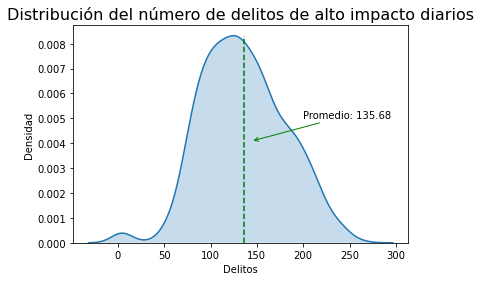

In [115]:
sns.kdeplot(data=delitos_diarios['conteo'], shade=True)
plt.axvline(x=delitos_diarios['conteo'].mean(), ymax=0.95, linestyle='--', color='green')
plt.annotate(
    'Promedio: ' + '{:,.2f}'.format(delitos_diarios['conteo'].mean()),
    xy=(delitos_diarios['conteo'].mean(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color='green', shrinkB=10))
plt.title('Distribución del número de delitos de alto impacto diarios', fontdict={'fontsize': 16})
plt.xlabel('Delitos')
plt.ylabel('Densidad')
plt.legend().remove()
plt.show()

In [116]:
# Cargamos el shapefile
alcadias = gpd.read_file(shp_path)

# Creamos la base de datos para que lo pueda corre la paquetería de GeoPandas
gdf = crimes_impacto.copy()
gdf['Coordinates'] = list(zip(gdf['longitud'], gdf['latitud']))
gdf['Coordinates'] = gdf['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})

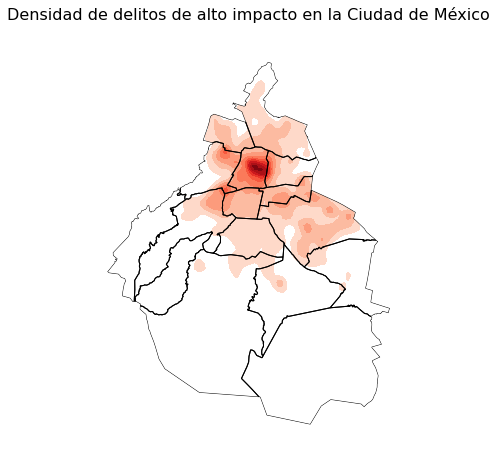

In [117]:
# Creamos una base de GeoPandas con las coordenadas de los delitos
fig = plt.figure(figsize=(8, 8))

ax = fig.subplots(1, 1)

gplt.kdeplot(gdf, cmap='Reds', shade=True, clip=alcadias, ax=ax)
gplt.polyplot(alcadias, zorder=1, ax=ax)
plt.title('Densidad de delitos de alto impacto en la Ciudad de México', fontdict={'fontsize': 16})
plt.show()

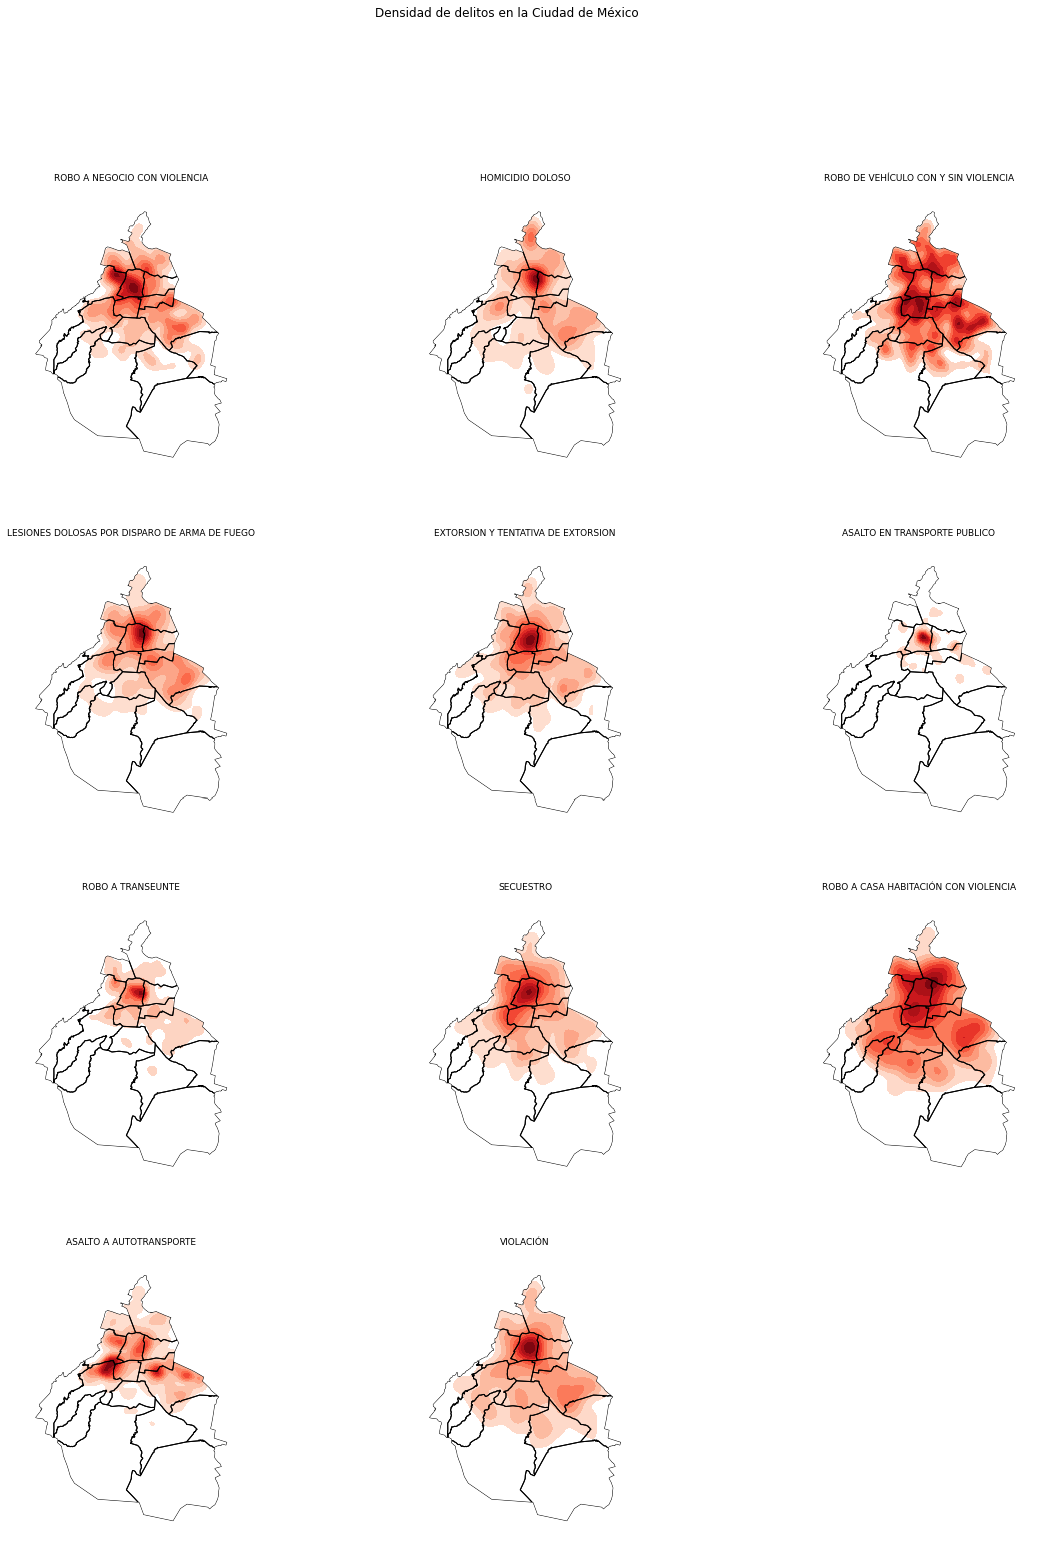

In [118]:
delitos = list(gdf['categoria_delito'].unique())

fig = plt.figure(figsize=(20, 25))
ax = fig.subplots(4, 3)

for a in ax:
    for b in a:
        b.set_visible(False)

for i , delito in enumerate(delitos):
    
    data = gdf.loc[gdf['categoria_delito'] == delito]
    
    ax_ = fig.add_subplot(4, 3, i+1)

    gplt.kdeplot(data, cmap='Reds', shade=True, clip=alcadias, ax=ax_)
    gplt.polyplot(alcadias, zorder=1, ax=ax_)
    
    ax_.set_title(delito, fontsize=9) 


plt.suptitle('Densidad de delitos en la Ciudad de México', fontsize=12)
plt.show()

# 3. Modelos de Aprendizaje de Máquina

## 3.1 Preparación de los datos

Vamos a utilizar un modelo de Multiclasificación con la varibale de categoria_delito 

In [119]:
# Convertimos nuestra Y a una variable categórica
labelencoder = LabelEncoder()
crimes_impacto['categoria_delito_cat'] = labelencoder.fit_transform(crimes_impacto['categoria_delito'])

In [120]:
# Vamos a crear variables categóricas para que puedan ser usadas en el modelo
crimes_impacto['Anio'] = crimes_impacto['fecha_hechos'].dt.year
crimes_impacto['Dia_semana'] = crimes_impacto['fecha_hechos'].dt.dayofweek
crimes_impacto['Dia_semana_nombre'] = crimes_impacto['fecha_hechos'].dt.day_name()
crimes_impacto['Semana_anio'] = crimes_impacto['fecha_hechos'].dt.weekofyear
crimes_impacto['Mes'] = crimes_impacto['fecha_hechos'].dt.month
crimes_impacto['Hora'] = crimes_impacto['fecha_hechos'].dt.hour
crimes_impacto['fecha'] = crimes_impacto['fecha_hechos'].dt.date

In [121]:
# Creamos una variable para el número de días desde la fecha de inicio
crimes_impacto['n_dias'] = (crimes_impacto['fecha']  - crimes_impacto['fecha'].min()).apply(lambda x: x.days)

# Creamos unas variables con rangos de horarios y fines de semana
crimes_impacto['madrugada'] = [1 if (crimes_impacto.loc[x, 'fecha_hechos'].hour >= 0) and 
                                    (crimes_impacto.loc[x, 'fecha_hechos'].hour < 6) 
                               else 0
                               for x in crimes_impacto.index]

crimes_impacto['maniana'] = [1 if (crimes_impacto.loc[x, 'fecha_hechos'].hour >= 6) and 
                                    (crimes_impacto.loc[x, 'fecha_hechos'].hour < 12) 
                               else 0
                               for x in crimes_impacto.index]

crimes_impacto['tarde'] = [1 if (crimes_impacto.loc[x, 'fecha_hechos'].hour >= 12) and 
                                    (crimes_impacto.loc[x, 'fecha_hechos'].hour < 19) 
                               else 0
                               for x in crimes_impacto.index]

crimes_impacto['noche'] = [1 if (crimes_impacto.loc[x, 'fecha_hechos'].hour >= 19) and 
                                    (crimes_impacto.loc[x, 'fecha_hechos'].hour <= 23) 
                               else 0
                               for x in crimes_impacto.index]


crimes_impacto['sabado'] = [1 if (crimes_impacto.loc[x, 'Dia_semana'] == 5) 
                               else 0
                               for x in crimes_impacto.index]

crimes_impacto['domingo'] = [1 if (crimes_impacto.loc[x, 'Dia_semana'] == 6) 
                               else 0
                               for x in crimes_impacto.index]


In [122]:
# Creamos una dummie para la alcadía
crimes_impacto = pd.get_dummies(crimes_impacto, columns=['alcaldia_hechos'])

In [123]:
# Declaramos nuestras features

features = ['longitud', 'latitud', 'Anio', 'Dia_semana', 'Semana_anio', 'Mes','Hora', 'n_dias',
            'madrugada', 'maniana', 'tarde', 'noche', 'sabado', 'domingo',
            'alcaldia_hechos_ALVARO OBREGON',
            'alcaldia_hechos_AZCAPOTZALCO', 
            'alcaldia_hechos_BENITO JUAREZ',
            'alcaldia_hechos_COYOACAN', 
            'alcaldia_hechos_CUAJIMALPA DE MORELOS',
            'alcaldia_hechos_CUAUHTEMOC', 
            'alcaldia_hechos_GUSTAVO A MADERO',
            'alcaldia_hechos_IZTACALCO', 
            'alcaldia_hechos_IZTAPALAPA',
            'alcaldia_hechos_LA MAGDALENA CONTRERAS',
            'alcaldia_hechos_MIGUEL HIDALGO', 
            'alcaldia_hechos_MILPA ALTA',
            'alcaldia_hechos_TLAHUAC', 
            'alcaldia_hechos_TLALPAN',
            'alcaldia_hechos_VENUSTIANO CARRANZA', 
            'alcaldia_hechos_XOCHIMILCO']

In [124]:
# Creamos una muestra de la base con el fin de que sea más rápido el cálculo
crimes_impacto = crimes_impacto.sample(frac = 0.1, random_state = 42)

# Creamos nuestras variables
y = crimes_impacto['categoria_delito_cat']

X = crimes_impacto[features]

# Renombramos las columnas para que no tenga nombres largos
X.columns = ['longitud', 'latitud', 'Anio', 'Dia_semana', 'Semana_anio', 'Mes','Hora', 'n_dias',
            'madrugada', 'maniana', 'tarde', 'noche', 'sabado', 'domingo',
            'ALVARO OBREGON',
            'AZCAPOTZALCO', 
            'BENITO JUAREZ',
            'COYOACAN', 
            'CUAJIMALPA',
            'CUAUHTEMOC', 
            'GUSTAVO A',
            'IZTACALCO', 
            'IZTAPALAPA',
            'LA MAGDALENA ',
            'MIGUEL HIDALGO', 
            'MILPA ALTA',
            'TLAHUAC', 
            'TLALPAN',
            'VENUSTIANO', 
            'XOCHIMILCO']

In [125]:
# Así se categorizan los delitos
crimes_impacto['del_unique'] = crimes_impacto['categoria_delito_cat'].astype('str') +  ': ' + crimes_impacto['categoria_delito']

crimes_impacto.sort_values(by='categoria_delito_cat', inplace=True)

for x in list(crimes_impacto['del_unique'].unique()):
    print(x)

0: ASALTO A AUTOTRANSPORTE
1: ASALTO EN TRANSPORTE PUBLICO
2: EXTORSION Y TENTATIVA DE EXTORSION
3: HOMICIDIO DOLOSO
4: LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO
5: ROBO A CASA HABITACIÓN CON VIOLENCIA
6: ROBO A NEGOCIO CON VIOLENCIA
7: ROBO A TRANSEUNTE
8: ROBO DE VEHÍCULO CON Y SIN VIOLENCIA
9: SECUESTRO
10: VIOLACIÓN


In [126]:
# Separamos los datos en training y test, en donde dejamos el dafault que separa el 75% de la meustra en training y el resto en test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## 3.2 KNN

In [127]:
acc_knn = []

neighbors = [x for x in range(1,500,5)]

for neig in tqdm(neighbors):
    
    knn = KNeighborsClassifier(n_neighbors = neig, n_jobs=-1)
    
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    
    acc_knn.append(np.mean(scores))


100%|██████████| 100/100 [03:41<00:00,  2.21s/it]


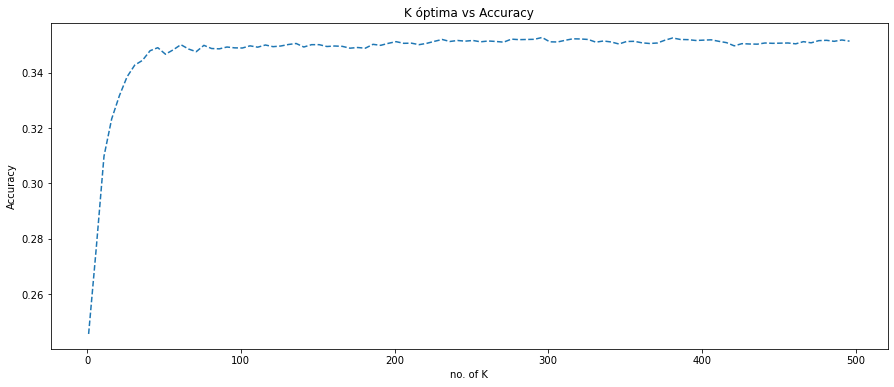

In [128]:
plt.figure(figsize=(15,6))

plt.plot(neighbors, acc_knn, linestyle='dashed', markersize='1')
plt.xlabel('no. of K')
plt.ylabel('Accuracy')
plt.title('K óptima vs Accuracy')
plt.show()

In [129]:
opt_k_knn = neighbors[np.argmax(acc_knn)]


knn_opt = KNeighborsClassifier(n_neighbors = opt_k_knn, n_jobs=-1).fit(X_train, y_train)

opt_acc_knn_test = knn_opt.score(X_test, y_test)

print('El valor de Accuracy del mejor modelo de KNN es {} con una k de {}'.format(opt_acc_knn_test, opt_k_knn))

El valor de Accuracy del mejor modelo de KNN es 0.35377358490566035 con una k de 296


## 3.3 Tree

In [130]:
##  Creamos el arbol de decisión
tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

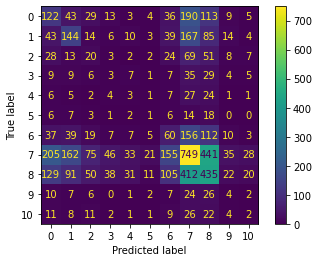

In [131]:
plot_confusion_matrix(tree, X_test, y_test)
plt.show()

In [132]:
# Estimamos el clasification report F1 = 2 * (precision * recall) / (precision + recall)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.20      0.22      0.21       567
           1       0.27      0.27      0.27       529
           2       0.09      0.09      0.09       227
           3       0.02      0.03      0.03       115
           4       0.03      0.04      0.03        81
           5       0.02      0.02      0.02        58
           6       0.13      0.13      0.13       455
           7       0.40      0.38      0.39      1950
           8       0.32      0.32      0.32      1344
           9       0.04      0.04      0.04        89
          10       0.03      0.02      0.02        97

    accuracy                           0.28      5512
   macro avg       0.14      0.14      0.14      5512
weighted avg       0.28      0.28      0.28      5512



Como hay muy poca precisión en nuestro primer modelo, vamos a mejorarlo.

Queremos Minimizar la siguiente función de complejidad:

$$R_\alpha(T) = R(T) + \alpha|T|$$


In [133]:
# Utilizamos la función de cost_complexity_pruning_path para estimar una lista de las diferentes alphas que puede tomar el modelo
alphas = tree.cost_complexity_pruning_path(X_train, y_train).ccp_alphas 

# Sacamos una muestra de la aplhas para que no sea tan costoso calcularlas
alphas = pd.Series(alphas).sample(frac = 0.01, random_state = 42)

lista_modelos = []

lista_accuracy = []

depth_list = []

## Creamos un modelo de arboles de decisión por cada alpha posible
for alpha in tqdm(np.unique(alphas)):
    
    tree_ = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha).fit(X_train, y_train)
    
    # Lo hacemos con cross validation y 5 folds
    scores = cross_val_score(tree_, X_train, y_train, cv=5)
    
    lista_accuracy.append(np.mean(scores))
    
    depth = tree_.get_n_leaves()
    
    lista_modelos.append(tree_)
    
    depth_list.append(depth)


100%|██████████| 36/36 [00:42<00:00,  1.17s/it]


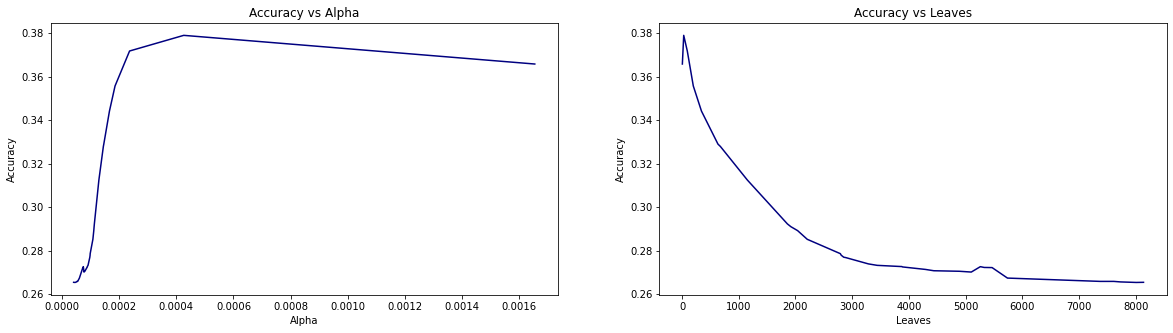

In [134]:
# Graficamos
fig = plt.figure(figsize=(20, 5))

ax1, ax2 = fig.subplots(1, 2)

ax1.plot(np.unique(alphas), lista_accuracy, color='navy')
ax1.set_ylabel('Accuracy'), ax1.set_xlabel('Alpha')
ax1.set_title('Accuracy vs Alpha')

ax2.plot(depth_list, lista_accuracy, color='navy')
ax2.set_ylabel('Accuracy'), ax2.set_xlabel('Leaves')
ax2.set_title('Accuracy vs Leaves')

plt.show()

In [135]:

alpha_op = np.unique(alphas)[np.argmax(lista_accuracy)]

tree_opt = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha_op).fit(X_train, y_train)

acc_pruned_tree_test = tree_opt.score(X_test, y_test)

print('El valor de alpha que genera una clasificación más exacta es: {}\nEl Accuracy es: {}\nY el arbol tiene {} hojas'.format(
    np.unique(alphas)[np.argmax(lista_accuracy)], 
    acc_pruned_tree_test,
    depth_list[np.argmax(lista_accuracy)]))

El valor de alpha que genera una clasificación más exacta es: 0.0004258062832284276
El Accuracy es: 0.3802612481857765
Y el arbol tiene 29 hojas


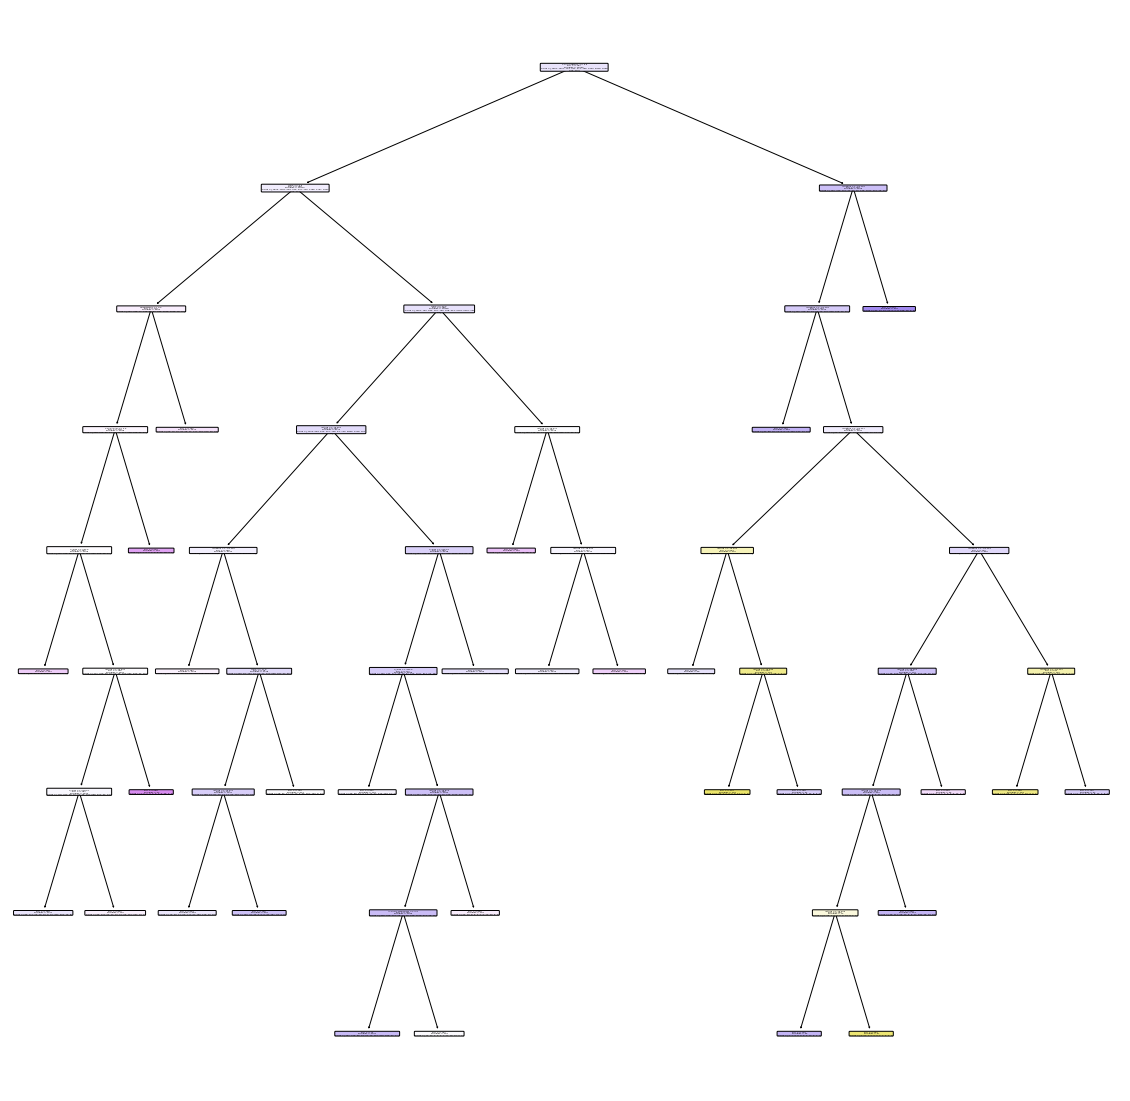

In [136]:
# Imprimimos el arbol
plt.figure(figsize=(20, 20))
plot_tree(lista_modelos[np.argmax(lista_accuracy)], 
          filled=True, 
          rounded=True, 
          feature_names=X.columns)
plt.show()

## 3.4 Random Forest

In [137]:
## Creamos el random forest en donde utilizamos el alpha que minimiza el mse del tree pasado y con n arboles

rango_forest = [i for i in range(20, 1000, 10)]
oob_list = []
accuracy_list = []

for n_arboles in tqdm(rango_forest):
    
    # Iteramos con el el número de arboles
    tree_forest = RandomForestClassifier(n_estimators=n_arboles, max_features= 'sqrt', bootstrap=True, max_samples = 1000, random_state=42, oob_score=True,
                                         ccp_alpha=alpha_op, n_jobs=-1).fit(X_train, y_train)
    
    
    oob = tree_forest.oob_score_
    
    # Lo hacemos con cross validation y 5 folds
    scores = cross_val_score(tree_forest, X_train, y_train, cv=5)
    
    oob_list.append(oob)
    
    accuracy_list.append(np.mean(scores))
    

100%|██████████| 196/196 [1:57:35<00:00, 36.00s/it]


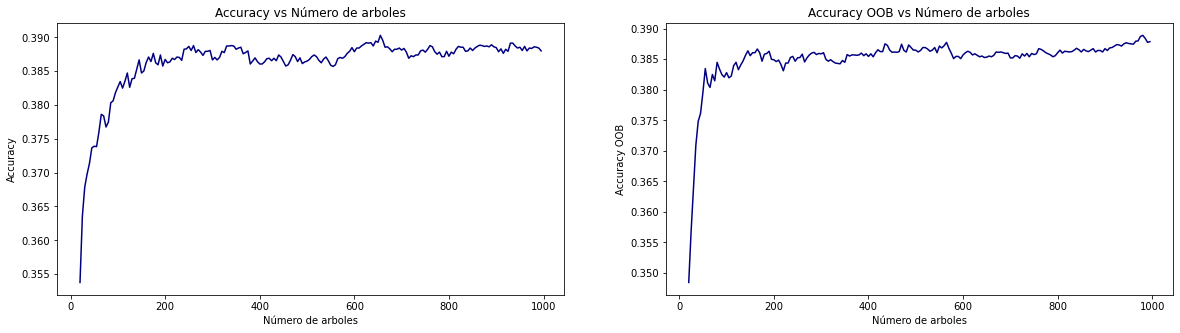

In [138]:
# Graficamos
fig = plt.figure(figsize=(20, 5))

ax1, ax2 = fig.subplots(1, 2)

ax1.plot(rango_forest, accuracy_list, color='navy')
ax1.set_ylabel('Accuracy'), ax1.set_xlabel('Número de arboles')
ax1.set_title('Accuracy vs Número de arboles')

ax2.plot(rango_forest, oob_list, color='navy')
ax2.set_ylabel('Accuracy OOB'), ax2.set_xlabel('Número de arboles')
ax2.set_title('Accuracy OOB vs Número de arboles')

plt.show()

In [139]:
forest_opt = rango_forest[np.argmax(accuracy_list)]

tree_forest_opt = RandomForestClassifier(n_estimators=n_arboles, max_features= 'sqrt', bootstrap=True, max_samples = 1000, random_state=42, oob_score=True,
                                         ccp_alpha=alpha_op, n_jobs=-1).fit(X_train, y_train)

acc_random_forest_test = tree_forest_opt.score(X_test, y_test)

print('El valor de arboles que genera una clasificación más exacta es: {}\nEl Accuracy es: {}\nY el accuracy del OOB es {} '.format(
    forest_opt, 
    acc_random_forest_test,
    oob_list[np.argmax(accuracy_list)]))

El valor de arboles que genera una clasificación más exacta es: 655
El Accuracy es: 0.38098693759071117
Y el accuracy del OOB es 0.385522496371553 


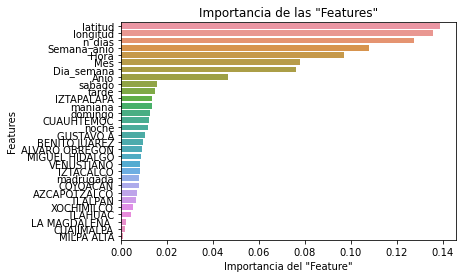

In [140]:
tree_forest_ = RandomForestClassifier(n_estimators=rango_forest[np.argmax(accuracy_list)], 
                                      max_features= 'sqrt', bootstrap=True, max_samples = 1000, random_state=42, oob_score=True,
                                      ccp_alpha=alpha_op).fit(X_train, y_train)

# Calculamos la imrpotancia de cada variable
feature_imp = pd.Series(tree_forest_.feature_importances_,index=X.columns).sort_values(ascending=False)

#Graficamos
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Importancia del "Feature"')
plt.ylabel('Features')
plt.title('Importancia de las "Features"')
plt.show()

## 3.5 Gradient Boosting

In [143]:
learning_r = [i/100 for i in range(1,101, 5)]

accuracy_list_gb = []
predict_stages = []

for lr in tqdm(learning_r):
    
    tree_gb_ = GradientBoostingClassifier(learning_rate= lr, n_estimators=500, random_state=42, subsample=.5,
                                         ccp_alpha=alpha_op).fit(X_train, y_train)
    
    # Lo hacemos con cross validation y 5 folds
    scores = cross_val_score(tree_gb_, X_train, y_train, cv=5)
    
    
    accuracy_list_gb.append(np.mean(scores))
    
    predict_stages.append(tree_gb_.staged_predict(X_test))

100%|██████████| 20/20 [3:49:42<00:00, 689.11s/it]  


In [144]:
opt_learning_rate = learning_r[np.argmax(accuracy_list_gb)]

tree_gb_opt = GradientBoostingClassifier(learning_rate= opt_learning_rate, n_estimators=500, random_state=42, subsample=.5,
                                         ccp_alpha=alpha_op).fit(X_train, y_train)

acc_gb_test = tree_gb_opt.score(X_test, y_test)


print('El valor de learning rate que genera una clasificación más exacta es: {}\nEl Accuracy es: {}'.format(opt_learning_rate, acc_gb_test))

El valor de learning rate que genera una clasificación más exacta es: 0.21
El Accuracy es: 0.38370827285921627


In [145]:
tree_gb = GradientBoostingClassifier(learning_rate= opt_learning_rate, n_estimators=500, random_state=42, subsample=.5,
                                     ccp_alpha=alpha_op).fit(X_train, y_train)

stages_best_gb = tree_gb.staged_predict(X_test)


In [146]:

# Primero creamos un loop para extraer los generadores y obtenemos una lista con el numero de modelos 

stages_best_gb_ = [x for x in stages_best_gb]

stages_acc = []

# Hacemos otro loop para extraer los valores de accuracy de cada uno de los modelos
for x in range(len(stages_best_gb_)):

    score = tree_gb.score(X_test, stages_best_gb_[x])

    stages_acc.append(score)


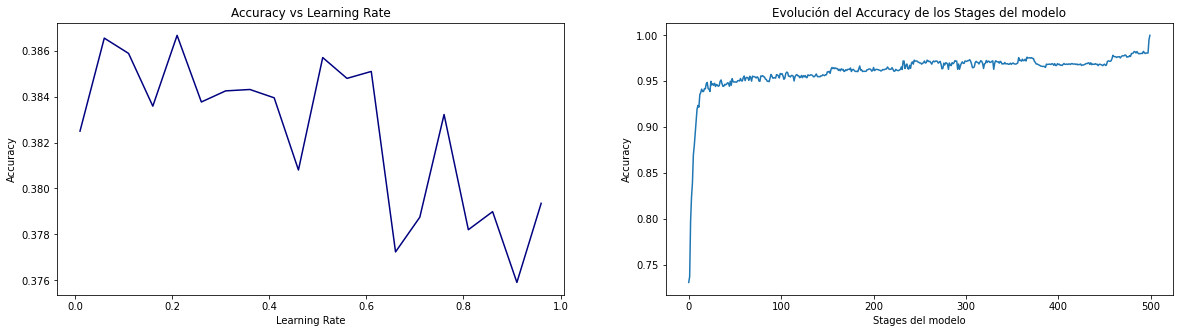

In [147]:
# Graficamos
fig = plt.figure(figsize=(20, 5))

ax1, ax2 = fig.subplots(1, 2)

ax1.plot(learning_r, accuracy_list_gb, color='navy')
ax1.set_ylabel('Accuracy'), ax1.set_xlabel('Learning Rate')
ax1.set_title('Accuracy vs Learning Rate')


ax2.plot(range(len(stages_best_gb_)), stages_acc) 
ax2.set_ylabel('Accuracy'), ax2.set_xlabel('Stages del modelo')
ax2.set_title('Evolución del Accuracy de los Stages del modelo')

plt.show()

## 3.6 XGBoost

In [148]:
# Convertimos los datos en DMatriz, que la paquetería íde para el cálculo del XGBoost
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [149]:
learning_rate = [x/100 for x in range(1,100,5)]

acc_list_xgb = []

## Corremos un loop para encontrar el learning rate con menor error
for lr in tqdm(learning_rate):
    
    xg_tree = xgb.XGBClassifier(objective ='multi:softmax', learning_rate = lr, n_estimators = 250, subsample = .4).fit(X_train, y_train)
    
    scores = cross_val_score(xg_tree, X_train, y_train, cv=5)
    
    acc_list_xgb.append(np.mean(scores))

100%|██████████| 20/20 [45:11<00:00, 135.55s/it]


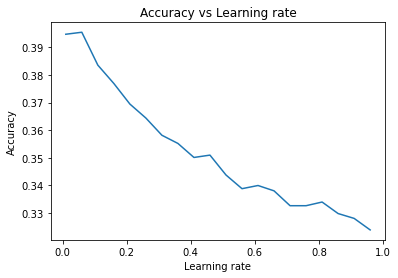

In [150]:
## Graficamos
plt.plot(learning_rate, acc_list_xgb) 
plt.ylabel('Accuracy'), plt.xlabel('Learning rate')
plt.title('Accuracy vs Learning rate')
plt.show()

In [151]:
opt_lr_xb = learning_rate[np.argmax(acc_list_xgb)]

xg_tree_opt = xgb.XGBClassifier(objective ='multi:softmax', learning_rate = opt_lr_xb, n_estimators = 250, subsample = .4).fit(X_train, y_train)

opt_acc_xb_test = xg_tree_opt.score(X_test, y_test)

print('El valor de Accuracy del mejor modelo de XGBoost es {}'.format(opt_acc_xb_test))

El valor de Accuracy del mejor modelo de XGBoost es 0.3953193033381713


# 4. Resultados

In [152]:
# Ahora comparamos los Accuracy de los modelos
modelos = pd.DataFrame({'KNN': [opt_acc_knn_test],
                        'Tree pruned': [acc_pruned_tree_test],
                        'Random Forest': [acc_random_forest_test],
                        'Gradient Boosting Tree': [acc_gb_test],
                        'XGBoosting': [opt_acc_xb_test]})

modelos

,KNN,Tree pruned,Random Forest,Gradient Boosting Tree,XGBoosting
0,0.353774,0.380261,0.380987,0.383708,0.395319
